# Preamble

## Imports

In [183]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib_venn import venn2
from datetime import datetime
from ast import literal_eval

## Lists

In [184]:
# Attributes to split monsters query
attributes = ['DIVINE', 'LIGHT', 'DARK', 'WATER', 'EARTH', 'FIRE', 'WIND']

# API variables
api_url = 'https://yugipedia.com/api.php'

# Styling dictionaries
arrows_dict = {'Middle-Left': '\u2190', 'Middle-Right': '\u2192', 'Top-Left': '\u2196', 'Top-Center': '\u2191', 'Top-Right': '\u2197', 'Bottom-Left': '\u2199', 'Bottom-Center': '\u2193', 'Bottom-Right': '\u2198'}
card_colors = {'Effect Monster': '#FF8B53', 'Normal Monster': '#FDE68A', 'Ritual Monster': '#9DB5CC', 'Fusion Monster': '#A086B7', 'Synchro Monster': '#CCCCCC', 'Xyz Monster': '#000000', 'Link Monster': '#00008B', 'Pendulum Monster': 'r', 'Monster Card': '#FF8B53', 'Spell Card': '#1D9E74', 'Trap Card': '#BC5A84', 'Monster Token': '#C0C0C0', 'FIRE': '#fd1b1b', 'WATER': '#03a9e6', 'EARTH': '#060d0a', 'WIND': '#77bb58', 'DARK': '#745ea5', 'LIGHT': '#9d8047', 'DIVINE': '#7e6537', 'Level': '#f1a41f'}

## Formatting functions

In [262]:
def extract_results(df):
    df = pd.DataFrame(df['query']['results']).transpose()
    df = pd.DataFrame(df['printouts'].values.tolist())
    return df

def extract_artwork(row):
    result = tuple()
    if 'Category:OCG/TCG cards with alternate artworks' in row:
        result += ('Alternate',)
    if 'Category:OCG/TCG cards with edited artworks' in row:
        result += ('Edited',)
    if result == tuple():
        return np.nan
    else:
        return result

def format_df(input_df):
    df = pd.DataFrame()
    if 'Name' in input_df.columns:
        df['Name'] = input_df['Name'].dropna().apply(lambda x: x[0])
    if 'Password' in input_df.columns:
        df['Password'] = input_df['Password'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Card type' in input_df.columns:
        df['Card type'] = input_df['Card type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Property' in input_df.columns:
        df['Property'] = input_df['Property'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Primary type' in input_df.columns:
        df['Primary type'] = input_df['Primary type'].dropna().apply(lambda x: [i['fulltext'] for i in x] if len(x)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Pendulum Monster', y)) if len(y)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Effect Monster', y))[0] if len(y)>1 else (y[0] if len(y)>0 else np.nan))
    if 'Secondary type' in input_df.columns:
        df['Secondary type'] = input_df['Secondary type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Attribute' in input_df.columns:
        df['Attribute'] = input_df['Attribute'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Monster type' in input_df.columns:
        df['Monster type'] = input_df['Monster type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Level/Rank' in input_df.columns:
        df['Level/Rank'] = input_df['Level/Rank'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'ATK' in input_df.columns:
        df['ATK'] = input_df['ATK'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'DEF' in input_df.columns:
        df['DEF'] = input_df['DEF'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Pendulum Scale' in input_df.columns:
        df['Pendulum Scale'] = input_df['Pendulum Scale'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link' in input_df.columns:
        df['Link'] = input_df['Link'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link Arrows' in input_df.columns:
        df['Link Arrows'] = input_df['Link Arrows'].dropna().apply(lambda x: tuple([arrows_dict[i] for i in sorted(x)]) if len(x)>0 else np.nan)
    if 'Effect type' in input_df.columns:
        df['Effect type'] = input_df['Effect type'].dropna().apply(lambda x: tuple(sorted([i['fulltext'] for i in x])) if len(x)>0 else np.nan)
    if 'Archseries' in input_df.columns:
        df['Archseries'] = input_df['Archseries'].dropna().apply(lambda x: tuple(sorted(x)) if len(x)>0 else np.nan)
    if 'Category' in input_df.columns:
        df['Artwork'] = input_df['Category'].dropna().apply(lambda x: [i['fulltext'] for i in x] if len(x)>0 else np.nan).apply(extract_artwork)
    if 'TCG status' in input_df.columns:
        df['TCG status'] = input_df['TCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'OCG status' in input_df.columns:
        df['OCG status'] = input_df['OCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Modification date' in input_df.columns:
        df['Modification date'] = input_df['Modification date'].dropna().apply(lambda x: pd.Timestamp(int(x[0]['timestamp']), unit='s').ctime() if len(x)>0 else np.nan)
    
    return df

def concat_errata(row):
    result = tuple()
    if row['Name errata']:
        result += ('Name',)
    if row['Type errata']:
        result += ('Type',)
    if result == tuple():
        return np.nan
    else:
        return result 

## API call functions

In [263]:
def card_query(_password = True, _card_type = True, _property = True, _primary = True, _secondary = True, _attribute = True, _monster_type = True, _stars = True, _atk = True, _def = True, _scale = True, _link = True, _arrows = True, _effect_type = True, _archseries = True, _category = True, _tcg = True, _ocg = True, _date = True):
    search_string = f'|?English%20name=Name'
    if _password:
        search_string += '|?Password'
    if _card_type:
        search_string += '|?Card%20type'
    if _property:    
        search_string += '|?Property'
    if _primary:
        search_string += '|?Primary%20type'
    if _secondary:
        search_string += '|?Secondary%20type'
    if _attribute:
        search_string += '|?Attribute'
    if _monster_type:
        search_string += '|?Type=Monster%20type'
    if _stars:
        search_string += '|?Stars%20string=Level%2FRank%20'
    if _atk:
        search_string += '|?ATK%20string=ATK'
    if _def:
        search_string += '|?DEF%20string=DEF'
    if _scale:
        search_string += '|?Pendulum%20Scale'
    if _link:
        search_string += '|?Link%20Rating=Link'
    if _arrows:
        search_string += '|?Link%20Arrows'
    if _effect_type:
        search_string += '|?Effect%20type'
    if _archseries:
        search_string += '|?Archseries'
    if _category:
        search_string += '|?category'
    if _tcg:
        search_string += '|?TCG%20status'
    if _ocg:
        search_string += '|?OCG%20status'
    if _date:
        search_string += '|?Modification%20date'
    
    return search_string

def fetch_spell(spell_query, limit = 5000):
    print('Downloading Spells')
    spell_df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Spell%20Cards]]{spell_query}|limit%3D{limit}|order%3Dasc&format=json')
    spell_df = extract_results(spell_df)
    print(f'{len(spell_df.index)} results\n')
    
    return spell_df

def fetch_trap(trap_query, limit = 5000):
    print('Downloading Traps')
    trap_df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Trap%20Cards]]{trap_query}|limit%3D{limit}|order%3Dasc&format=json')
    trap_df = extract_results(trap_df)
    print(f'{len(trap_df.index)} results\n')
    
    return trap_df

def fetch_monster(monster_query, step = 5000, limit = 5000):
    print('Downloading Monsters')
    monster_df = pd.DataFrame()
    for att in attributes:
        print(f"- {att}")
        for i in range(int(limit/step)):
            df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20monsters]][[Attribute::{att}]]{monster_query}|limit%3D{step}|offset={i*step}|order%3Dasc&format=json')
            df = extract_results(df)
            print(f'Iteration {i+1}: {len(df.index)} results')
            monster_df = pd.concat([monster_df, df], ignore_index=True, axis=0)
            if len(df.index)<step:
                break
        
    print(f'- Total\n{len(monster_df.index)} results')
    
    return monster_df

def fetch_name_errata(limit = 1000):
    name_query_df = pd.read_json(f'{api_url}?action=ask&query=[[Category:Cards%20with%20name%20errata]]|limit={limit}|order%3Dasc&format=json')
    name_keys = list(name_query_df['query']['results'].keys())
    return pd.DataFrame(True, index = [i.split(':')[1].strip() for i in name_keys if 'Card Errata:' in i], columns = ['Name errata'])

def fetch_type_errata(limit = 1000):
    type_query_df = pd.read_json(f'{api_url}?action=ask&query=[[Category:Cards%20with%20card%20type%20errata]]|limit={limit}|order%3Dasc&format=json')
    type_keys = list(type_query_df['query']['results'].keys())
    return pd.DataFrame(True, index = [i.split(':')[1].strip() for i in type_keys if 'Card Errata:' in i], columns = ['Type errata'])

# Data aquisition

## Fetch online data

In [261]:
monster_query = card_query(_property = False)
st_query = card_query(_primary = False, _secondary = False, _attribute = False, _monster_type = False, _stars = False, _atk = False, _def = False, _scale = False, _link = False, _arrows = False)
# Timestamp
timestamp = pd.Timestamp.now().timestamp()
full_df = pd.DataFrame()

# Fetch Spell
spell_df = fetch_spell(st_query)
full_df = pd.concat([full_df, spell_df], ignore_index=True, axis=0)

# Fetch Trap
trap_df = fetch_trap(st_query)
full_df = pd.concat([full_df, trap_df], ignore_index=True, axis=0)
st_df = pd.concat([spell_df, trap_df], ignore_index=True, axis=0)

# Fetch Monster
monster_df = fetch_monster(monster_query, step=1000, limit = 5000)
full_df = pd.concat([full_df, monster_df], ignore_index=True, axis=0)

# Fetch erratas
# errata_df = pd.concat([fetch_name_errata(), fetch_type_errata()], axis=1)

2312 results

1776 results

- DIVINE
Iteration 1: 9 results
- LIGHT
Iteration 1: 1000 results
Iteration 2: 599 results
- DARK
Iteration 1: 1000 results
Iteration 2: 1000 results
Iteration 3: 179 results
- WATER
Iteration 1: 815 results
- EARTH
Iteration 1: 1000 results
Iteration 2: 848 results
- FIRE
Iteration 1: 647 results
- WIND
Iteration 1: 755 results
- Total
7852 results


## Format data

In [320]:
formatted_spell_df = format_df(spell_df)
formatted_trap_df = format_df(trap_df)
formatted_st_df = format_df(st_df)
formatted_monster_df = format_df(monster_df)
formatted_full_df = format_df(full_df)
print('Data formated')

Data formated


## Save data

In [17]:
formatted_full_df.to_csv(f'Data/All_cards_{int(timestamp)}.csv', index = False)
print('Data saved')

Data saved


# Check changes

## Load latest file

In [18]:
# Get list of files
list_of_files = sorted(glob.glob('Data/All_cards_*.csv'), key=os.path.getctime, reverse=True)
# Get second newest file if exist
if len(list_of_files)>1:
    latest_file = list_of_files[1]
    previous_df = pd.read_csv(latest_file, dtype=object)
    # Correct tuples
    previous_df['Effect type'] = previous_df['Effect type'].dropna().apply(literal_eval)
    previous_df['Link Arrows'] = previous_df['Link Arrows'].dropna().apply(literal_eval)
    previous_df['Archseries'] = previous_df['Archseries'].dropna().apply(literal_eval)
    print('File loaded')
else:
    print('No older files')

File loaded


## Generate changelog

In [19]:
if previous_df is not None:
    changelog = previous_df.merge(formatted_full_df,indicator = True, how='outer').loc[lambda x : x['_merge']!='both'].sort_values('Name', ignore_index=True)
    changelog['_merge'].replace(['left_only','right_only'],['Old', 'New'], inplace = True)
    changelog.rename(columns={"_merge": "Version"}, inplace = True)
    nunique = changelog.groupby('Name').nunique()
    cols_to_drop = nunique[nunique < 2].dropna(axis=1).columns
    changelog = changelog.set_index('Name')[nunique > 1]
    changelog.drop(cols_to_drop, axis=1, inplace = True)
    changelog
else:
    print('No changes')

# Data visualisation

## Full data

In [20]:
formatted_full_df

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
0,"""A"" Cell Breeding Device",34541863,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Trigger Effect,)",NaN,NaN,Unlimited,Unlimited,Sat Nov 6 13:57:15 2021
1,"""A"" Cell Incubator",64163367,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Continuous-like Effect, Trigger Effect)",NaN,NaN,Unlimited,Unlimited,Mon Jun 13 04:27:51 2022
2,"""A"" Cell Recombination Device",91231901,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Effect, Ignition-like Effect)",NaN,NaN,Unlimited,Unlimited,Thu Mar 12 22:40:14 2020
3,"""A"" Cell Scatter Burst",73262676,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Effect,)",NaN,NaN,Unlimited,Unlimited,Sat Nov 6 13:58:32 2021
4,"""Infernoble Arms - Durendal""",37478723,Spell Card,Equip Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(Condition, Ignition-like Effect, Trigger Effect)","(Noble Arms,)",NaN,Unlimited,Unlimited,Sat Nov 27 20:48:13 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11935,Yosenju Shinchu L,65025250,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,2100,3,NaN,NaN,"(Continuous Effect, Continuous-like Effect, Tr...","(Yosenju,)",NaN,Unlimited,Unlimited,Thu Nov 18 15:52:59 2021
11936,Yosenju Shinchu R,91420254,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,2100,5,NaN,NaN,"(Continuous Effect, Ignition-like Effect, Trig...","(Yosenju,)",NaN,Unlimited,Unlimited,Thu Nov 18 15:53:07 2021
11937,Yosenju Tsujik,25244515,Monster Card,NaN,Effect Monster,NaN,WIND,Beast-Warrior,4,1000,0,NaN,NaN,NaN,"(Condition, Ignition Effect, Quick Effect, Tri...","(Yosenju,)",NaN,Unlimited,Unlimited,Sun Dec 20 18:15:02 2020
11938,ZW - Eagle Claw,29353756,Monster Card,NaN,Effect Monster,NaN,WIND,Winged Beast,5,2000,1200,NaN,NaN,NaN,"(Continuous-like Effect, Ignition Effect, Uncl...","(ZW -, Zexal)",NaN,Unlimited,Unlimited,Thu Jul 8 13:48:07 2021


## Card types

In [21]:
formatted_full_df.groupby('Card type').nunique()

,Name,Password,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Card type,,,,,,,,,,,,,,,,,,,
Monster Card,7844,7731,0,8,6,7,25,15,83,78,13,6,60,221,956,3,7,7,7787
Spell Card,2310,2290,6,0,0,0,0,0,0,0,0,0,0,113,387,3,5,6,2296
Trap Card,1776,1760,3,0,0,0,0,0,0,0,0,0,0,92,317,3,5,6,1767


<AxesSubplot:>

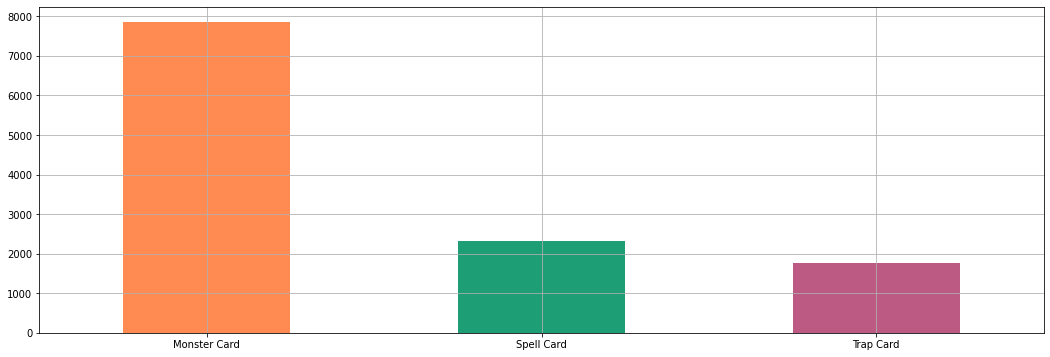

In [22]:
card_type_colors = [card_colors[i] for i in formatted_full_df['Card type'].value_counts().index]
formatted_full_df['Card type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = card_type_colors)
plt.show()

## Monsters

### Attributes

In [23]:
print('Total number of attributes:', formatted_monster_df['Attribute'].nunique())

Total number of attributes: 7


In [24]:
formatted_monster_df.drop(columns=['Card type']).groupby('Attribute').nunique()

,Name,Password,Primary type,Secondary type,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Attribute,,,,,,,,,,,,,,,,,
DARK,2176,2143,7,6,23,14,70,63,12,6,39,152,439,3,7,7,2168
DIVINE,6,0,1,0,2,2,3,3,0,0,0,6,3,1,2,2,7
EARTH,1846,1826,7,6,23,12,71,59,11,4,29,125,316,3,5,6,1842
FIRE,647,643,8,6,22,12,43,40,8,4,20,82,179,3,3,6,645
LIGHT,1599,1566,7,6,23,14,58,50,10,5,30,129,373,3,7,6,1590
WATER,815,807,7,6,22,11,56,41,9,4,16,90,196,3,7,7,815
WIND,755,746,7,6,23,12,47,39,11,4,14,103,209,3,6,6,750


<AxesSubplot:>

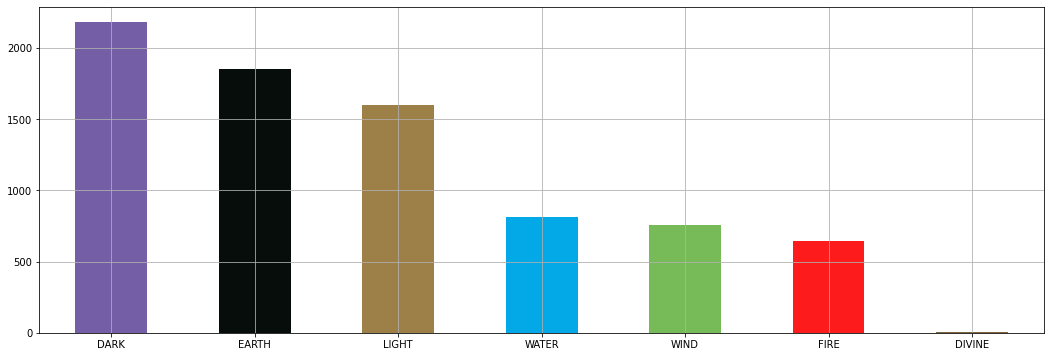

In [25]:
attribute_colors = [card_colors[i] for i in formatted_full_df['Attribute'].value_counts().index]
formatted_monster_df['Attribute'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = attribute_colors)
plt.show()

### Primary types

In [26]:
print('Total number of primary types:', formatted_monster_df['Primary type'].nunique())

Total number of primary types: 8


In [27]:
formatted_monster_df.drop(columns=['Card type']).groupby('Primary type').nunique()

,Name,Password,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Primary type,,,,,,,,,,,,,,,,,
Effect Monster,5334,5285,6,7,25,12,74,67,13,0,0,203,747,3,6,6,5297
Fusion Monster,417,414,1,6,23,12,48,46,3,0,0,65,137,3,4,5,417
Link Monster,360,353,0,6,23,0,38,0,0,6,60,50,136,3,4,5,360
Monster Token,1,0,0,1,1,1,1,1,0,0,0,0,1,0,0,1,1
Normal Monster,744,700,1,6,23,10,59,49,10,0,0,6,128,3,4,4,745
Ritual Monster,115,115,2,6,15,12,33,26,1,0,0,31,36,2,2,1,115
Synchro Monster,400,395,1,6,23,13,40,38,4,0,0,55,151,2,5,6,399
Xyz Monster,477,469,0,6,23,14,51,42,4,0,0,66,186,3,4,6,475


#### Has effect discrimination

In [28]:
has_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].notna()).value_counts().rename('Effect')
no_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].isna()).value_counts().rename('No Effect')
effect = pd.concat([has_effect,no_effect], axis=1)
effect

,Effect,No Effect
Effect Monster,5333.0,1
Xyz Monster,475.0,2
Synchro Monster,397.0,3
Fusion Monster,355.0,62
Link Monster,355.0,5
Ritual Monster,99.0,16
Normal Monster,34.0,711
Monster Token,NaN,1


<AxesSubplot:>

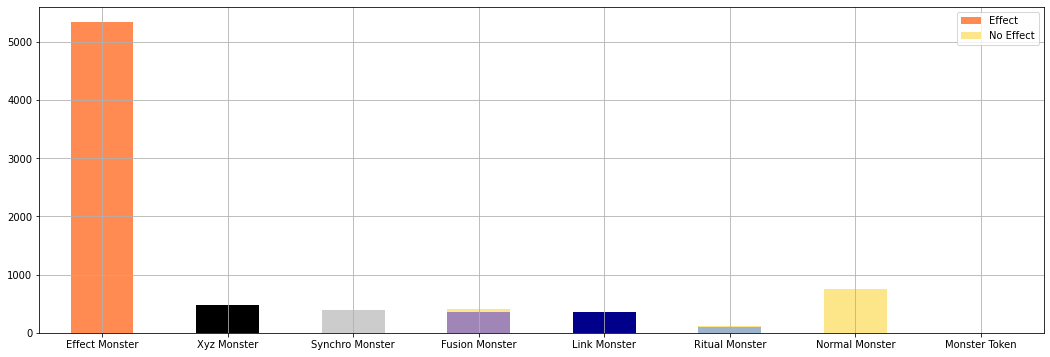

In [29]:
monster_type_colors = {'No Effect': card_colors['Normal Monster'], 'Effect': [card_colors[i] for i in effect.index]}
effect.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0,  legend=True, color = monster_type_colors)
plt.show()

Normal monster can have effect if it is pendulum

#### Is pendulum discrimination

In [30]:
not_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].isna()).value_counts().rename('Not Pendulum')
is_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].notna()).value_counts().rename('Pendulum')
pendulum = pd.concat([not_pendulum,is_pendulum], axis=1)
pendulum

,Not Pendulum,Pendulum
Effect Monster,5074,260.0
Normal Monster,707,38.0
Xyz Monster,470,7.0
Fusion Monster,408,9.0
Synchro Monster,395,5.0
Link Monster,360,NaN
Ritual Monster,114,1.0
Monster Token,1,NaN


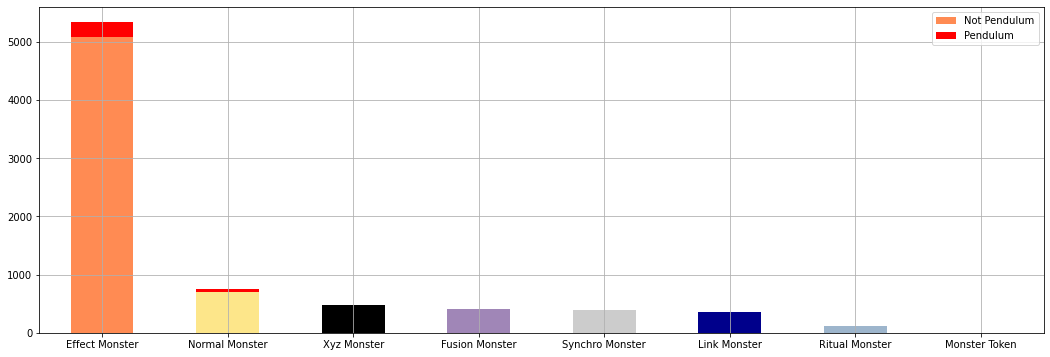

In [148]:
monster_type_colors_b = {'Pendulum': card_colors['Pendulum Monster'], 'Not Pendulum': [card_colors[i] for i in pendulum.index]}
pendulum.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = monster_type_colors_b, legend=True)
plt.show()

#### By attribute

In [32]:
primmary_crosstab = pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Attribute'])
primmary_crosstab

Attribute,DARK,DIVINE,EARTH,FIRE,LIGHT,WATER,WIND
Primary type,,,,,,,
Effect Monster,1468,6,1282,436,1081,539,522
Fusion Monster,141,0,79,34,96,34,33
Link Monster,116,0,74,31,86,28,25
Monster Token,0,0,0,1,0,0,0
Normal Monster,186,0,250,52,81,109,67
Ritual Monster,34,0,17,7,32,19,6
Synchro Monster,104,0,67,50,74,32,73
Xyz Monster,130,0,79,36,149,54,29


<AxesSubplot:xlabel='Primary type', ylabel='Attribute'>

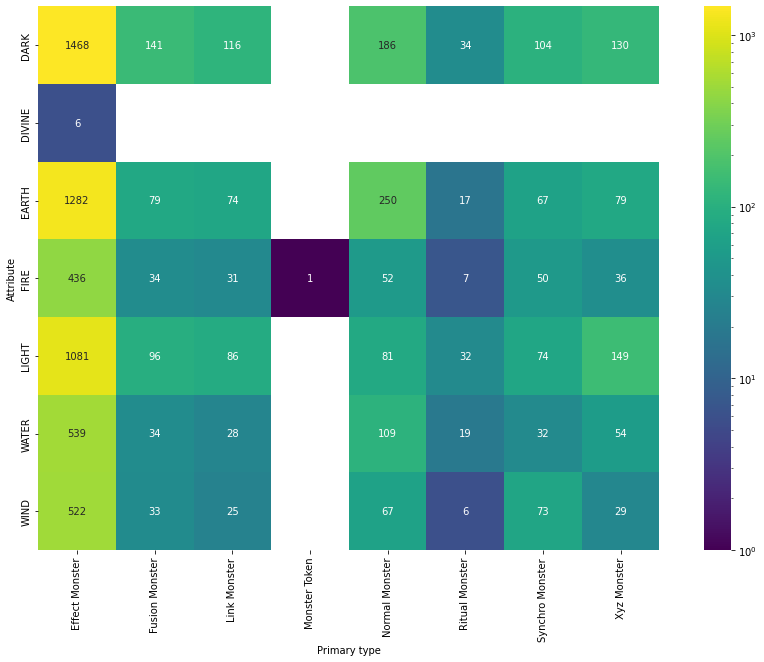

In [33]:
plt.figure(figsize = (16,10))
sns.heatmap(primmary_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

### Secondary types

In [34]:
print('Total number of secondary types:', formatted_monster_df['Secondary type'].nunique())

Total number of secondary types: 6


In [35]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Secondary type').nunique()

,Name,Password,Primary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Secondary type,,,,,,,,,,,,,,,
Flip monster,180,179,1,6,19,12,38,33,1,18,44,2,3,5,180
Gemini monster,45,45,1,6,18,8,17,19,0,6,13,0,1,1,45
Spirit monster,36,36,2,6,13,9,22,20,2,7,4,1,2,2,36
Toon monster,17,17,1,6,7,5,12,15,0,8,13,1,1,2,17
Tuner monster,457,453,5,6,23,9,32,32,7,56,128,3,3,5,456
Union monster,37,37,1,6,9,8,17,14,0,6,9,1,1,1,37


<AxesSubplot:>

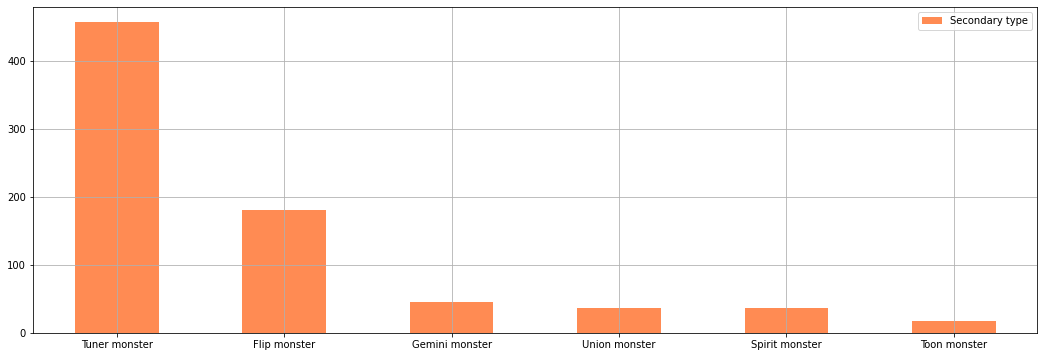

In [36]:
secondary_type_colors = card_colors['Effect Monster']
formatted_monster_df['Secondary type'].value_counts().plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = secondary_type_colors, legend=True)
plt.show()

#### By attribute

In [37]:
secondary_crosstab = pd.crosstab(formatted_full_df['Secondary type'],formatted_full_df['Attribute'])
secondary_crosstab

Attribute,DARK,EARTH,FIRE,LIGHT,WATER,WIND
Secondary type,,,,,,
Flip monster,50,60,9,31,13,17
Gemini monster,11,8,8,6,8,4
Spirit monster,5,6,6,4,6,9
Toon monster,7,5,1,2,1,1
Tuner monster,118,91,42,90,48,68
Union monster,6,9,3,12,4,3


<AxesSubplot:xlabel='Attribute', ylabel='Secondary type'>

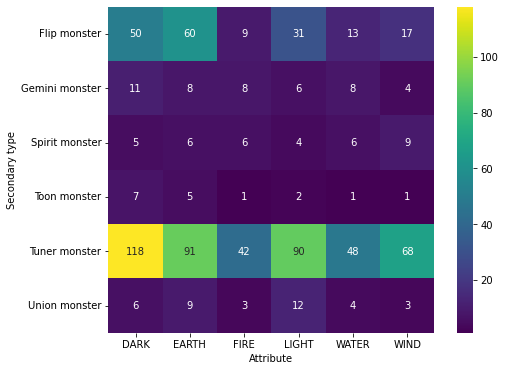

In [38]:
plt.figure(figsize = (8,6))
sns.heatmap(secondary_crosstab, annot=True, fmt="g", cmap='viridis', square=True)
plt.show()

#### By secondary type

In [39]:
secondary_crosstab_b = pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Secondary type'], margins = True)
secondary_crosstab_b

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster,All
Primary type,,,,,,,
Effect Monster,180,45,34,17,412,37,725
Fusion Monster,0,0,0,0,3,0,3
Normal Monster,0,0,0,0,12,0,12
Ritual Monster,0,0,2,0,1,0,3
Synchro Monster,0,0,0,0,29,0,29
All,180,45,36,17,457,37,772


<AxesSubplot:xlabel='Secondary type', ylabel='Primary type'>

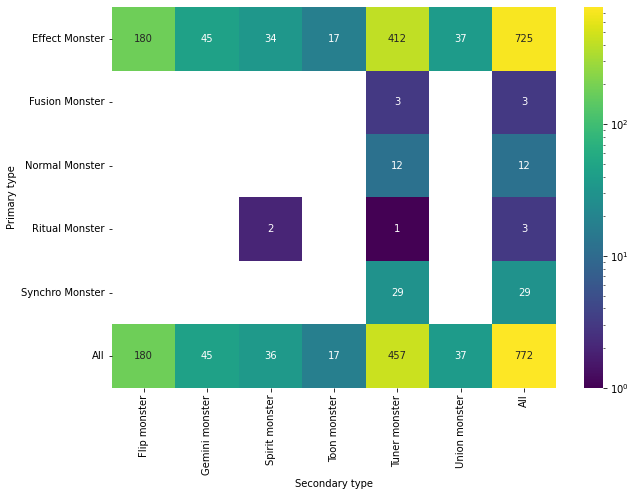

In [40]:
plt.figure(figsize = (10,7))
sns.heatmap(secondary_crosstab_b, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

### Monster types

In [41]:
print('Total number of monster types:', formatted_monster_df['Monster type'].nunique())

Total number of monster types: 25


In [42]:
formatted_monster_df.drop(columns=['Card type']).groupby('Monster type').nunique()

,Name,Password,Primary type,Secondary type,Attribute,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Monster type,,,,,,,,,,,,,,,,,
Aqua,255,251,7,6,6,10,50,33,3,2,3,51,64,2,3,5,255
Beast,372,365,7,4,6,10,48,38,7,2,7,59,80,3,4,5,373
Beast-Warrior,235,230,7,3,6,10,36,29,6,3,7,58,47,3,4,6,234
Creator God,1,0,1,0,1,1,1,1,0,0,0,1,1,0,0,1,1
Cyberse,244,242,7,1,6,10,30,29,1,6,37,45,33,2,3,4,244
Dinosaur,121,119,6,1,6,10,35,30,4,2,3,35,23,1,3,4,121
Divine-Beast,5,0,1,0,1,1,3,3,0,0,0,5,2,1,2,2,6
Dragon,647,640,7,6,6,13,52,48,9,5,19,109,180,2,6,7,645
Fairy,495,485,7,5,6,12,43,38,8,4,12,76,105,3,7,5,491


<AxesSubplot:>

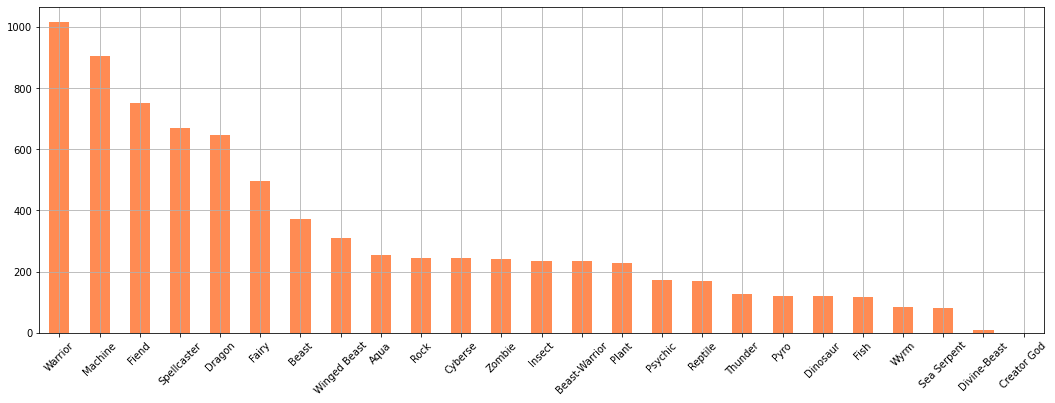

In [43]:
monster_type_colors = card_colors['Monster Card']
formatted_monster_df['Monster type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = monster_type_colors)
plt.show()

#### By Attribute

In [44]:
monster_crosstab = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Attribute'], dropna=False)
monster_crosstab

Attribute,DARK,DIVINE,EARTH,FIRE,LIGHT,WATER,WIND
Monster type,,,,,,,
Aqua,10,0,6,10,4,219,6
Beast,36,0,211,16,72,14,24
Beast-Warrior,36,0,82,53,33,16,15
Creator God,0,1,0,0,0,0,0
Cyberse,62,0,36,43,63,28,12
Dinosaur,11,0,59,32,5,8,6
Divine-Beast,0,8,0,0,0,0,0
Dragon,249,0,47,48,162,28,113
Fairy,53,0,57,15,320,25,25


<AxesSubplot:xlabel='Monster type', ylabel='Attribute'>

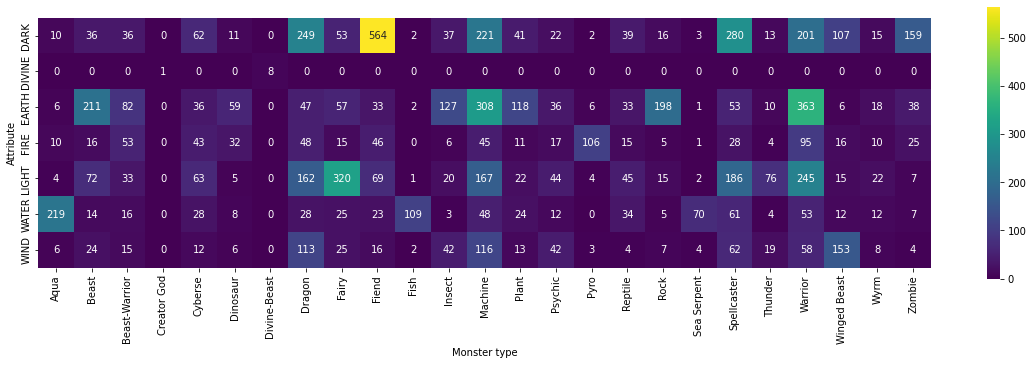

In [45]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True)
plt.show()

#### By primary type

In [46]:
monster_crosstab_b = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Primary type'], dropna=False)
monster_crosstab_b

Primary type,Effect Monster,Fusion Monster,Link Monster,Monster Token,Normal Monster,Ritual Monster,Synchro Monster,Xyz Monster
Monster type,,,,,,,,
Aqua,154,11,3,0,59,8,3,17
Beast,268,16,9,0,54,1,14,11
Beast-Warrior,161,11,9,0,21,2,8,23
Creator God,1,0,0,0,0,0,0,0
Cyberse,122,4,92,0,7,6,5,8
Dinosaur,86,7,3,0,18,0,4,3
Divine-Beast,5,0,0,0,0,0,0,0
Dragon,341,62,33,0,45,15,93,58
Fairy,357,20,24,0,36,15,17,26


<AxesSubplot:xlabel='Monster type', ylabel='Primary type'>

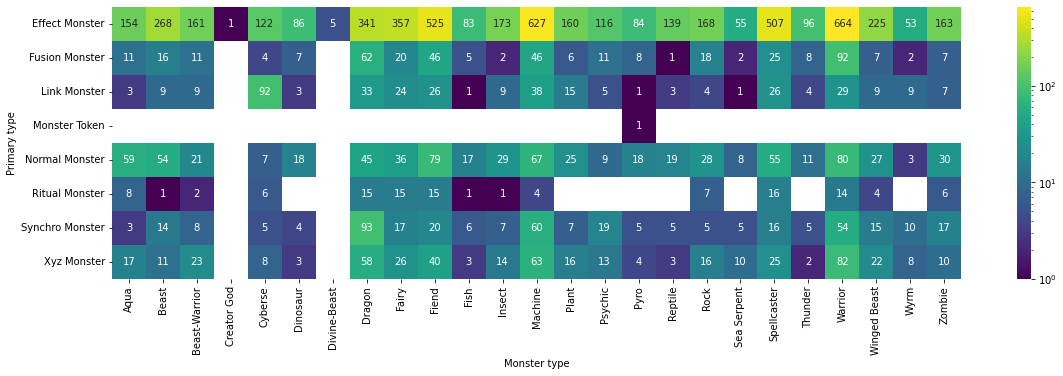

In [47]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())
plt.show()

#### By secondary type

In [48]:
monster_crosstab_c = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Secondary type'], dropna=False)
monster_crosstab_c

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster
Monster type,,,,,,
Aqua,4,4,1,1,10,3
Beast,15,1,2,0,22,0
Beast-Warrior,1,0,1,0,9,0
Cyberse,0,0,0,0,6,0
Dinosaur,0,0,0,0,7,0
Dragon,1,6,1,3,42,4
Fairy,6,2,7,0,20,5
Fiend,27,4,2,1,41,1
Fish,0,1,0,0,5,0


<AxesSubplot:xlabel='Monster type', ylabel='Secondary type'>

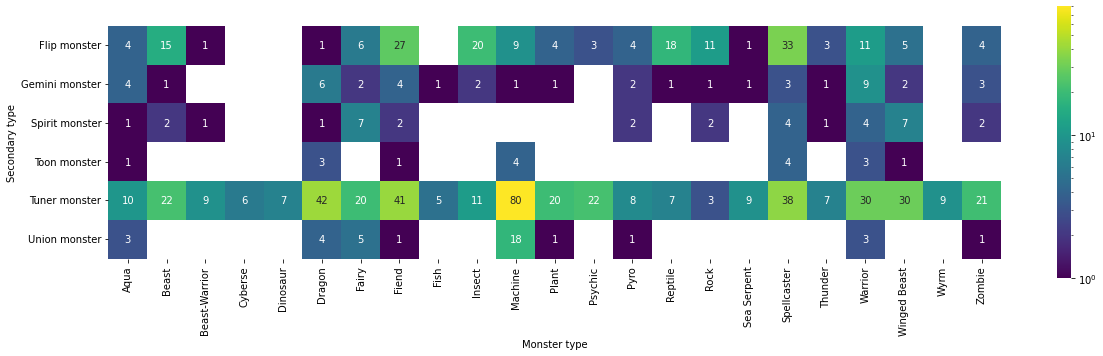

In [49]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab_c.T, annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())
plt.show()

### Effect type

In [50]:
print('Total number of effect types:', formatted_monster_df['Effect type'].explode().nunique())

Total number of effect types: 14


In [51]:
formatted_monster_df[formatted_monster_df['Effect type'].notna()].drop(columns=['Card type']).explode('Effect type').groupby('Effect type').nunique()

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Archseries,Artwork,TCG status,OCG status,Modification date
Effect type,,,,,,,,,,,,,,,,,
Activation condition,1,1,1,0,1,1,1,1,1,1,0,0,1,0,1,1,1
Condition,2934,2876,7,6,7,25,14,63,63,13,5,52,608,3,5,6,2912
Continuous Effect,2108,2093,6,5,7,24,14,59,52,12,6,48,540,3,4,4,2106
Continuous-like Effect,233,233,6,3,6,21,11,42,36,13,1,2,72,2,3,3,233
Flip effect,169,168,1,1,6,19,12,38,33,1,0,0,42,2,3,5,169
Ignition Effect,2538,2517,6,6,7,24,13,66,61,12,5,42,617,3,5,6,2524
Ignition-like Effect,214,205,6,2,6,20,12,35,32,13,1,1,73,1,3,5,214
Lingering effect,16,16,2,1,6,11,7,11,13,0,2,2,9,0,2,1,16
Maintenance cost,44,44,3,0,6,12,8,21,18,2,1,1,8,0,1,1,44


<AxesSubplot:>

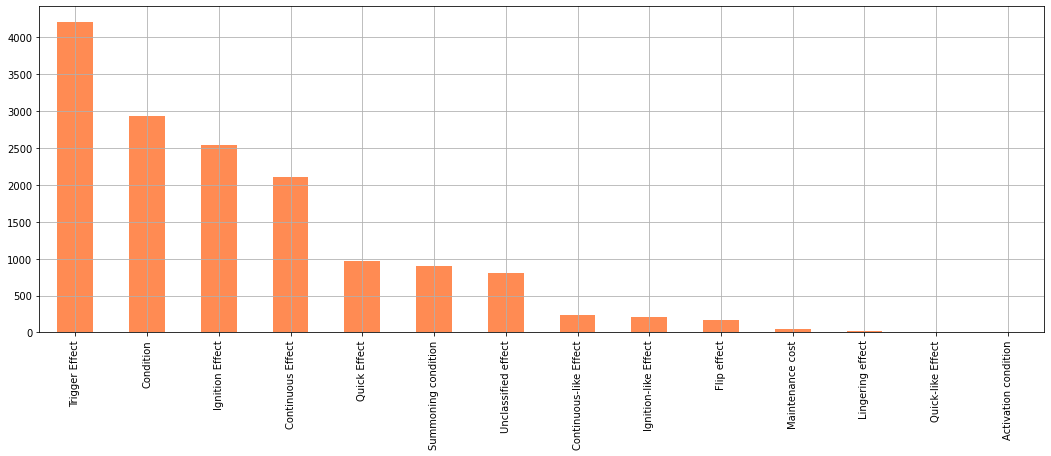

In [52]:
monster_effect_colors = card_colors['Effect Monster']
formatted_monster_df['Effect type'].explode('Effect type').value_counts().plot.bar(figsize = (18,6), grid = True, color = monster_effect_colors)
plt.show()

### ATK

In [53]:
print('Total number of ATK values:', formatted_monster_df['ATK'].nunique())

Total number of ATK values: 83


In [54]:
formatted_monster_df.drop(columns=['Card type']).groupby('ATK').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
ATK,,,,,,,,,,,,,,,,,
0,600,574,8,5,6,23,13,35,9,5,15,89,228,3,6,7,598
50,2,2,1,0,2,2,1,2,0,0,0,2,2,0,1,1,2
100,214,213,5,3,6,20,11,27,8,2,2,48,105,2,2,3,214
150,1,1,1,0,1,1,1,1,0,0,0,0,0,0,1,1,1
200,114,114,6,5,6,20,7,21,4,1,2,34,65,2,2,4,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,2,2,1,0,2,1,1,1,0,0,0,2,1,0,1,1,2
5000,9,9,5,0,3,4,2,4,0,1,1,8,6,1,1,1,9
?,83,74,6,1,7,20,15,8,2,1,1,34,35,2,5,4,83


<AxesSubplot:>

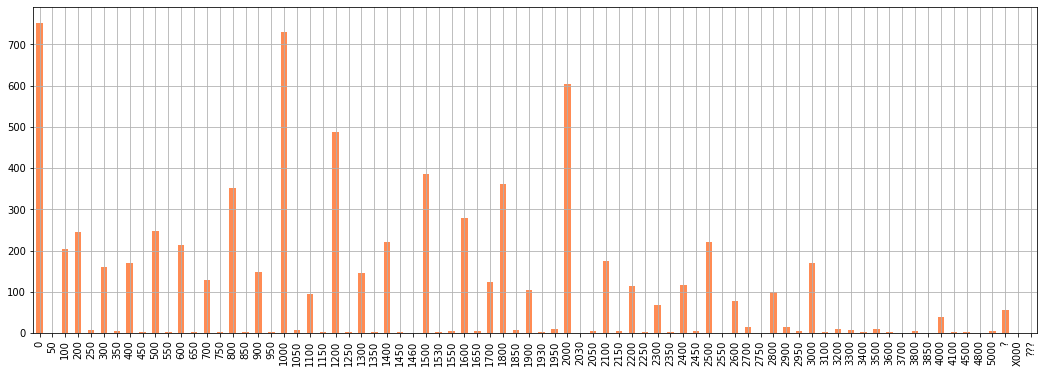

In [55]:
atk_colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = atk_colors)
plt.show()

### DEF

In [56]:
print('Total number of DEF values:', formatted_monster_df['DEF'].nunique())

Total number of DEF values: 78


In [57]:
formatted_monster_df.drop(columns=['Card type']).groupby('DEF').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
DEF,,,,,,,,,,,,,,,,,
0,753,723,7,6,6,23,14,45,10,0,0,101,252,3,5,6,750
50,1,1,1,0,1,1,1,1,0,0,0,1,1,0,1,1,1
100,204,203,5,4,6,19,10,24,8,0,0,45,92,2,3,3,203
200,246,244,5,5,6,23,10,31,5,0,0,47,105,3,3,4,246
250,8,8,2,1,4,5,2,4,0,0,0,5,3,0,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,1,1,1,0,1,1,1,1,0,0,0,1,1,0,1,1,1
5000,5,5,2,0,3,3,2,2,0,0,0,4,3,1,1,1,5
?,56,49,5,1,7,17,14,2,1,0,0,25,25,2,4,4,56


<AxesSubplot:>

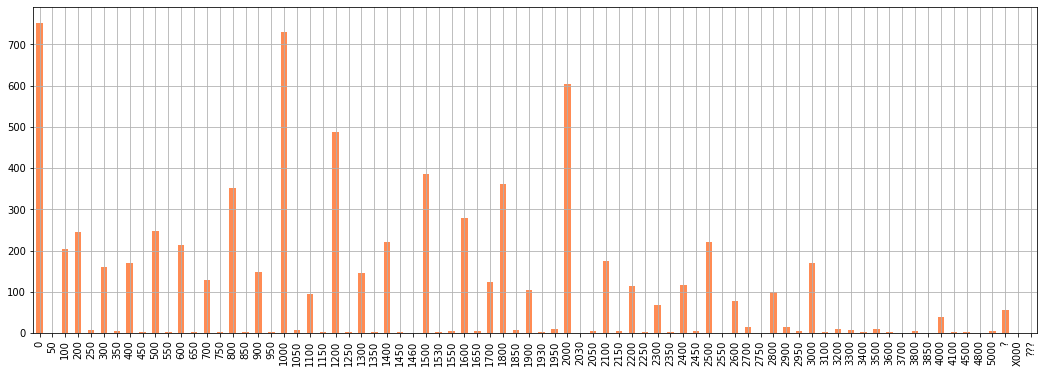

In [58]:
def_colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = def_colors)
plt.show()

### Level/Rank

In [59]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Level/Rank').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,ATK,DEF,Pendulum Scale,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Level/Rank,,,,,,,,,,,,,,,
0,6,6,2,0,2,2,3,3,0,5,3,0,2,2,6
1,622,596,7,5,6,23,22,29,10,79,223,3,4,5,620
2,659,648,6,5,6,23,30,30,7,71,207,2,5,6,658
3,1135,1129,6,5,6,23,41,36,9,92,286,3,4,7,1135
4,2310,2298,6,6,6,23,54,47,9,134,493,3,5,7,2302
5,589,588,6,6,6,23,46,38,8,83,232,3,4,3,589
6,591,586,6,6,6,23,38,38,9,90,228,3,6,6,591
7,459,450,6,6,6,23,36,35,9,99,218,3,5,6,461
8,654,637,6,5,6,23,42,41,8,111,294,3,5,5,656


<AxesSubplot:>

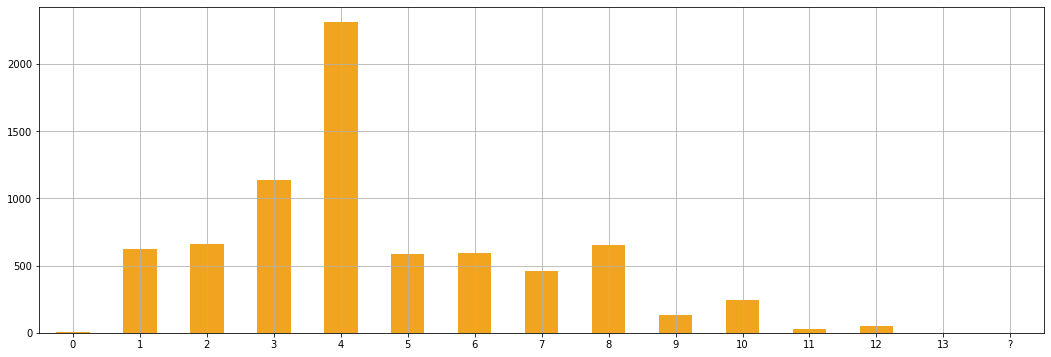

In [60]:
stars_colors = card_colors['Level']
formatted_monster_df['Level/Rank'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color= stars_colors)
plt.show()

#### ATK statistics

In [61]:
formatted_monster_df[['Level/Rank','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Level/Rank').describe()

ATK                                                         \
             count         mean          std  min     25%     50%     75%   
Level/Rank                                                                  
0              5.0   600.000000  1341.640786  0.0     0.0     0.0     0.0   
1            612.0   240.604575   353.260419  0.0     0.0   100.0   300.0   
2            656.0   584.908537   403.601335  0.0   300.0   500.0   800.0   
3           1132.0   960.733216   483.962143  0.0   600.0  1000.0  1300.0   
4           2298.0  1417.941688   541.259260  0.0  1200.0  1500.0  1800.0   
5            586.0  1763.344710   638.406194  0.0  1500.0  1900.0  2200.0   
6            588.0  2012.670068   612.995421  0.0  1900.0  2200.0  2400.0   
7            455.0  2292.197802   610.246217  0.0  2200.0  2500.0  2600.0   
8            646.0  2551.006192   703.834289  0.0  2500.0  2800.0  3000.0   
9            132.0  2602.651515   854.452067  0.0  2500.0  2800.0  3000.0   
10           223.0  2823.542601  1222.294588  0.0  2800.0  3000.0  3500.0   
11            30.0  2990.000000  1093.113238  0.0  3000.0  3350.0  3500.0   
12            44.0  3352.272727  1446.324714  0.0  3000.0  4000.0  4000.0   

                    
               max  
Level/Rank          
0           3000.0  
1           2500.0  
2           2400.0  
3           3000.0  
4           3000.0  
5           4000.0  
6           4000.0  
7           3300.0  
8           4500.0  
9           4500.0  
10          5000.0  
11          4000.0  
12          5000.0

#### DEF statistics

In [62]:
formatted_monster_df[['Level/Rank','DEF']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Level/Rank').describe()

DEF                                                         \
             count         mean          std  min     25%     50%     75%   
Level/Rank                                                                  
0              5.0   400.000000   894.427191  0.0     0.0     0.0     0.0   
1            614.0   339.983713   520.980535  0.0     0.0   100.0   400.0   
2            657.0   657.610350   551.711511  0.0   200.0   500.0   900.0   
3           1132.0   953.710247   569.517003  0.0   600.0   900.0  1300.0   
4           2300.0  1168.839130   606.491131  0.0   800.0  1200.0  1600.0   
5            587.0  1425.724020   671.433654  0.0  1000.0  1500.0  1900.0   
6            588.0  1561.105442   706.824101  0.0  1200.0  1650.0  2000.0   
7            457.0  1879.868709   651.415113  0.0  1600.0  2000.0  2300.0   
8            653.0  1978.101072   841.747056  0.0  1600.0  2100.0  2500.0   
9            132.0  2291.287879   805.953426  0.0  2000.0  2500.0  2925.0   
10           232.0  2232.543103  1284.231371  0.0  1900.0  2500.0  3000.0   
11            30.0  2661.666667  1169.415071  0.0  2125.0  3000.0  3400.0   
12            45.0  2837.777778  1688.098566  0.0  2000.0  3200.0  4000.0   

                    
               max  
Level/Rank          
0           2000.0  
1           2500.0  
2           2400.0  
3           3000.0  
4           3000.0  
5           3000.0  
6           3000.0  
7           3300.0  
8           4000.0  
9           3700.0  
10          5000.0  
11          4000.0  
12          5000.0

### Pendulum scale

In [63]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Pendulum Scale').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Pendulum Scale,,,,,,,,,,,,,,,
0,10,10,2,1,5,7,6,5,5,8,8,1,1,1,10
1,67,64,5,2,6,10,11,28,26,37,38,0,3,4,67
2,36,35,2,1,6,11,6,17,22,21,15,0,3,3,36
3,36,36,2,1,6,15,8,22,15,23,17,0,1,1,36
4,32,32,5,0,5,8,8,18,16,25,16,1,1,1,32
5,34,34,2,1,6,12,7,23,21,20,16,0,3,3,34
6,15,14,1,1,4,7,6,11,11,11,9,0,1,2,15
7,27,26,2,1,6,14,6,19,17,14,16,0,1,2,27
8,39,39,5,1,6,9,8,19,18,23,21,0,1,3,39


<AxesSubplot:>

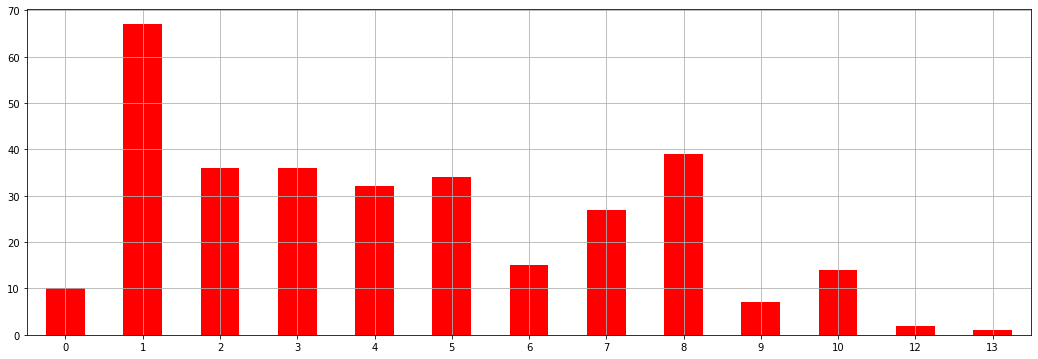

In [64]:
scales_colors = card_colors['Pendulum Monster']
formatted_monster_df['Pendulum Scale'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = scales_colors)
plt.show()

#### ATK statistics

In [65]:
formatted_monster_df[['Pendulum Scale','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

ATK                                                    \
               count         mean          std     min     25%     50%   
Pendulum Scale                                                           
0               10.0  1390.000000  1317.784336     0.0     0.0  1450.0   
1               66.0  1751.515152  1053.381723     0.0  1000.0  1800.0   
2               36.0  1423.611111   688.734462   100.0   800.0  1500.0   
3               36.0  1437.500000   845.354955     0.0   600.0  1725.0   
4               32.0  1787.500000  1011.785391     0.0  1100.0  2000.0   
5               34.0  1339.705882   808.831875     0.0   850.0  1325.0   
6               15.0  1320.000000   707.308783   100.0   950.0  1500.0   
7               27.0  1279.629630   787.920737     0.0   700.0  1400.0   
8               39.0  1225.641026   968.644726     0.0   300.0  1200.0   
9                7.0  2114.285714   781.938982  1000.0  1700.0  2400.0   
10              14.0  1678.571429  1376.829452     0.0   125.0  2500.0   
12               1.0   100.000000          NaN   100.0   100.0   100.0   
13               1.0     0.000000          NaN     0.0     0.0     0.0   

                                
                   75%     max  
Pendulum Scale                  
0               2500.0  3000.0  
1               2500.0  4000.0  
2               2000.0  2500.0  
3               2025.0  2600.0  
4               2550.0  3000.0  
5               1800.0  3450.0  
6               1800.0  2400.0  
7               1750.0  3000.0  
8               2000.0  3300.0  
9               2600.0  2800.0  
10              2875.0  3000.0  
12               100.0   100.0  
13                 0.0     0.0

#### DEF statistics

In [66]:
formatted_monster_df[['Pendulum Scale','DEF']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

DEF                                                    \
               count         mean          std     min     25%     50%   
Pendulum Scale                                                           
0               10.0  1200.000000  1273.664878     0.0     0.0   750.0   
1               67.0  1571.641791   940.310389     0.0   950.0  1700.0   
2               36.0  1338.888889   728.316171     0.0   875.0  1200.0   
3               36.0  1165.277778   788.834533     0.0   575.0  1200.0   
4               32.0  1534.375000   830.316448     0.0  1000.0  1600.0   
5               34.0  1136.764706   822.625953     0.0   550.0  1000.0   
6               15.0  1226.666667   711.604492   400.0   600.0  1100.0   
7               27.0  1312.962963   830.383669     0.0   700.0  1300.0   
8               39.0  1015.384615   789.916205     0.0   350.0  1000.0   
9                7.0  1257.142857   680.336051  1000.0  1000.0  1000.0   
10              14.0  1850.000000  1124.380171     0.0   750.0  2500.0   
12               1.0   100.000000          NaN   100.0   100.0   100.0   
13               1.0     0.000000          NaN     0.0     0.0     0.0   

                                
                   75%     max  
Pendulum Scale                  
0               2500.0  3000.0  
1               2350.0  4000.0  
2               1825.0  2700.0  
3               1800.0  3000.0  
4               2075.0  2800.0  
5               1575.0  3000.0  
6               1700.0  2600.0  
7               2000.0  2700.0  
8               1700.0  2700.0  
9               1000.0  2800.0  
10              2575.0  3000.0  
12               100.0   100.0  
13                 0.0     0.0

#### Level/Rank statistics

In [67]:
formatted_monster_df[['Pendulum Scale','Level/Rank']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

Level/Rank                                                
                    count      mean       std  min   25%  50%   75%   max
Pendulum Scale                                                           
0                    10.0  6.100000  3.348300  1.0  3.75  7.0  8.00  10.0
1                    67.0  5.955224  2.427324  1.0  4.00  6.0  8.00  12.0
2                    36.0  4.416667  1.380993  1.0  3.75  4.0  5.00   7.0
3                    36.0  4.444444  1.731134  1.0  4.00  4.0  5.00  10.0
4                    32.0  5.562500  2.154328  1.0  4.00  6.0  7.00   8.0
5                    34.0  4.176471  1.961301  1.0  3.00  4.0  4.00  11.0
6                    15.0  3.933333  1.579632  1.0  3.00  4.0  4.50   8.0
7                    27.0  4.185185  1.641693  2.0  3.00  4.0  5.00  10.0
8                    39.0  3.923077  2.355113  1.0  2.00  4.0  6.00  10.0
9                     7.0  5.714286  1.380131  4.0  5.00  5.0  6.50   8.0
10                   14.0  6.714286  2.812843  1.0  7.00  7.0  7.75  10.0
12                    2.0  6.500000  7.778175  1.0  3.75  6.5  9.25  12.0
13                    1.0  7.000000       NaN  7.0  7.00  7.0  7.00   7.0

### Link

In [68]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Secondary type','Level/Rank','DEF','Pendulum Scale']).groupby('Link').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Attribute,Monster type,ATK,Link Arrows,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Link,,,,,,,,,,,,
1,47,47,6,11,10,8,18,25,1,3,3,47
2,180,179,6,23,23,18,31,100,1,3,4,180
3,81,81,6,16,17,17,25,46,2,2,2,81
4,43,40,6,15,12,13,20,24,2,3,4,43
5,8,5,2,5,4,3,5,4,0,2,2,8
6,1,1,1,1,1,1,1,1,0,1,1,1


<AxesSubplot:>

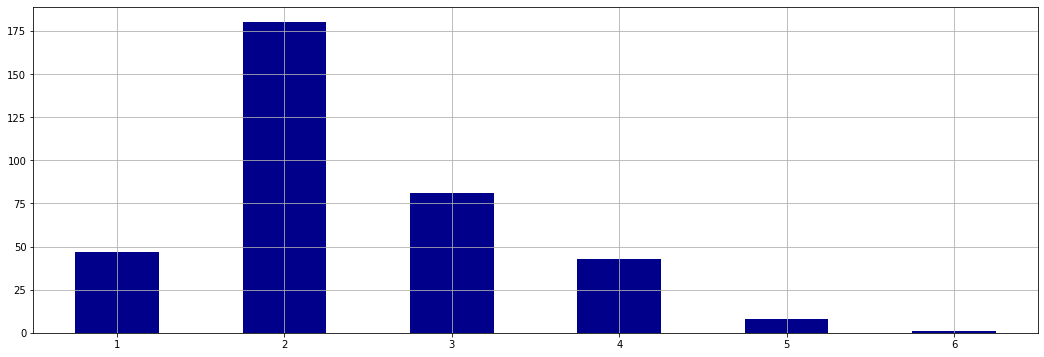

In [69]:
link_colors = card_colors['Link Monster']
formatted_monster_df['Link'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = link_colors)
plt.show()

#### ATK statistics

In [70]:
formatted_monster_df[['Link','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Link').describe()

ATK                                                                 
      count         mean         std     min     25%     50%     75%     max
Link                                                                        
1      47.0   736.170213  482.937358     0.0   400.0   800.0  1000.0  1500.0
2     180.0  1401.388889  512.672659     0.0  1100.0  1500.0  1800.0  2300.0
3      81.0  2258.641975  659.487970     0.0  2200.0  2400.0  2500.0  4000.0
4      42.0  2664.285714  661.418073     0.0  2525.0  2800.0  3000.0  3300.0
5       8.0  3250.000000  755.928946  2500.0  3000.0  3000.0  3125.0  5000.0
6       1.0     0.000000         NaN     0.0     0.0     0.0     0.0     0.0

### Link Arrows

#### By combination

In [71]:
print('Total number of link arrow combinations:', formatted_monster_df['Link Arrows'].nunique())

Total number of link arrow combinations: 60


In [72]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Link', 'Secondary type', 'DEF']).groupby('Link Arrows').nunique()

,Name,Password,Attribute,Monster type,ATK,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Link Arrows,,,,,,,,,,,
"(←,)",5,5,2,3,2,4,4,0,3,2,5
"(←, ↑)",4,4,2,3,4,3,2,0,1,1,4
"(←, →)",18,18,6,8,11,8,9,0,2,2,18
"(←, →, ↑)",7,7,3,5,6,6,5,0,1,1,7
"(↑,)",10,10,5,5,6,9,5,0,1,1,10
"(↑, ↖, ↗)",2,2,2,2,2,1,1,0,1,1,2
"(→,)",2,2,2,2,1,2,1,0,1,1,2
"(→, ↑)",2,2,2,2,2,1,1,0,1,1,2
"(↓,)",18,18,5,7,9,10,14,0,2,3,18


<AxesSubplot:>

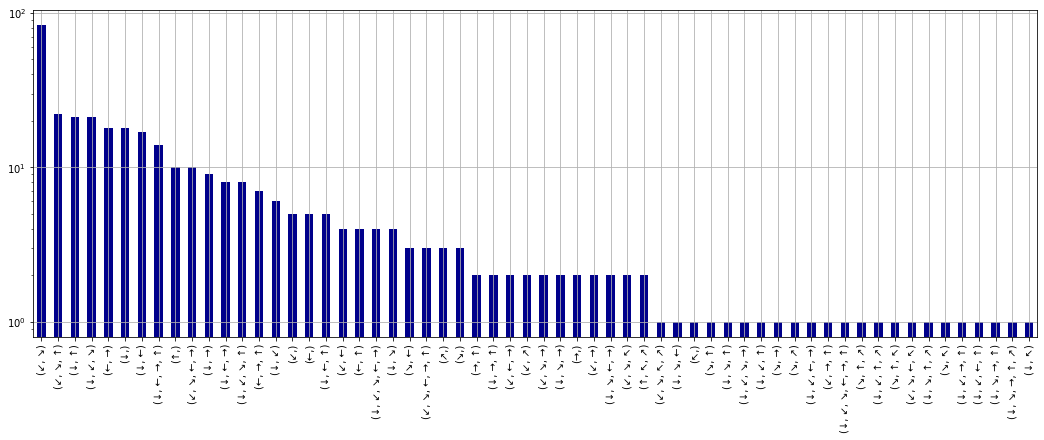

In [73]:
arrows_colors = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].value_counts().plot.bar(figsize = (18,6), logy=True, grid = True, color = arrows_colors)
plt.show()

#### By unique

In [74]:
formatted_monster_df[formatted_monster_df['Link Arrows'].notna()].drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Secondary type', 'DEF']).explode('Link Arrows').groupby('Link Arrows').nunique()

,Name,Password,Attribute,Monster type,ATK,Link,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Link Arrows,,,,,,,,,,,,
←,111,105,6,20,29,6,33,44,2,4,3,111
↑,113,110,6,18,27,6,30,44,2,3,4,113
→,97,91,6,18,27,6,28,40,2,3,3,97
↓,154,147,6,19,31,6,40,66,3,3,5,154
↖,10,10,5,5,9,4,6,5,1,1,2,10
↗,13,13,5,6,9,5,6,6,0,1,2,13
↘,184,180,6,22,32,6,35,101,3,4,5,184
↙,186,183,6,22,33,6,37,102,3,4,4,186


<AxesSubplot:>

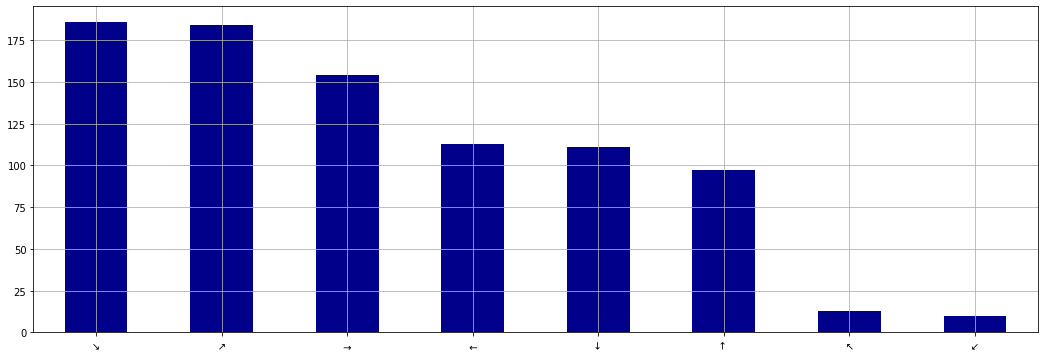

In [75]:
arrows_colors_b = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].explode('Link Arrows').value_counts().plot.bar(figsize = (18,6), grid = True, color = arrows_colors_b)
plt.show()

#### By link

In [76]:
arrow_per_link = formatted_monster_df[['Link Arrows','Link']].explode('Link Arrows').dropna()
arrow_crosstab = pd.crosstab(arrow_per_link['Link Arrows'],arrow_per_link['Link'])
arrow_crosstab

Link,1,2,3,4,5,6
Link Arrows,,,,,,
←,5,46,23,29,7,1
↑,10,28,43,27,4,1
→,2,32,24,30,8,1
↓,18,58,41,31,5,1
↖,1,2,5,2,0,0
↗,3,3,3,3,1,0
↘,3,94,53,25,8,1
↙,5,97,51,25,7,1


<AxesSubplot:xlabel='Link Arrows', ylabel='Link'>

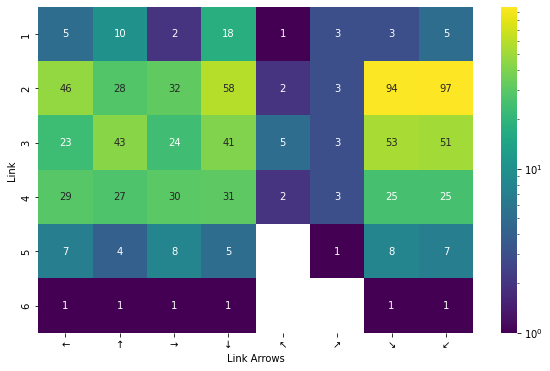

In [77]:
plt.figure(figsize = (10,6))
sns.heatmap(arrow_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

## Spell & Trap

### Properties

In [78]:
print('Total number of properties:', formatted_st_df['Property'].nunique())

Total number of properties: 9


In [79]:
formatted_st_df.drop(columns=['Card type']).groupby('Property').nunique()

,Name,Password,Effect type,Archseries,Artwork,TCG status,OCG status,Modification date
Property,,,,,,,,
Continuous Spell Card,405,401,53,155,3,5,5,403
Continuous Trap Card,484,475,63,159,2,4,4,484
Counter Trap Card,153,150,17,57,2,2,3,153
Equip Spell Card,256,256,36,72,1,2,2,256
Field Spell Card,265,260,35,139,2,5,5,266
Normal Spell Card,902,898,43,225,3,4,6,903
Normal Trap Card,1139,1135,47,231,3,4,6,1131
Quick-Play Spell Card,410,403,32,133,3,3,5,409
Ritual Spell Card,72,72,8,23,2,1,1,72


<AxesSubplot:>

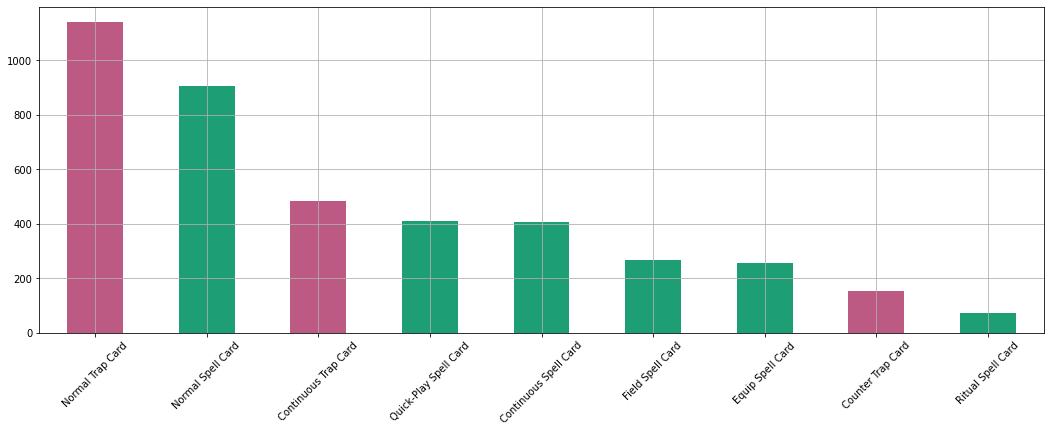

In [80]:
st_colors = [card_colors[i] for i in formatted_full_df[['Card type','Property']].value_counts().index.get_level_values(0)]
formatted_st_df['Property'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = st_colors)
plt.show()

### Effect type

In [81]:
print('Total number of effect types:', formatted_st_df['Effect type'].explode().nunique())

Total number of effect types: 14


In [82]:
formatted_st_df.explode('Effect type').groupby('Effect type').nunique()

,Name,Password,Card type,Property,Archseries,Artwork,TCG status,OCG status,Modification date
Effect type,,,,,,,,,
Activation condition,828,821,2,8,170,3,4,5,826
Condition,1609,1584,2,9,364,3,5,5,1596
Continuous Effect,18,18,2,6,10,0,1,1,18
Continuous-like Effect,878,867,2,7,230,3,5,5,878
Cost,449,447,2,7,110,3,4,4,449
Effect,2859,2835,2,9,418,3,5,6,2840
Ignition Effect,1,1,1,1,1,0,1,1,1
Ignition-like Effect,416,409,1,6,175,1,4,5,413
Lingering effect,93,93,2,6,40,2,3,3,93


#### Spell & Trap discrimination

In [83]:
spell = formatted_spell_df['Effect type'].explode('Effect type').value_counts().rename('Spell Card')
trap = formatted_trap_df['Effect type'].explode('Effect type').value_counts().rename('Trap Card')
st_diff = pd.concat([spell, trap], axis = 1)
st_diff

,Spell Card,Trap Card
Effect,1486.0,1374.0
Condition,1083.0,527.0
Continuous-like Effect,598.0,281.0
Trigger Effect,536.0,273.0
Ignition-like Effect,416.0,NaN
Activation condition,244.0,584.0
Cost,241.0,208.0
Unclassified effect,61.0,19.0
Lingering effect,56.0,37.0
Maintenance cost,11.0,11.0


<AxesSubplot:>

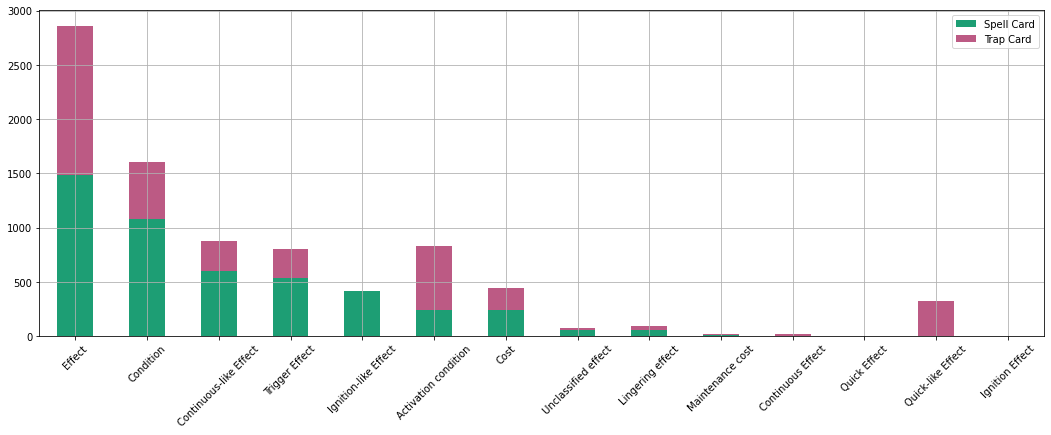

In [84]:
st_diff_colors = {'Spell Card': card_colors['Spell Card'], 'Trap Card': card_colors['Trap Card']}
st_diff.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=45, color = st_diff_colors)
plt.show()

## Archseries

In [85]:
exploded_archseries = formatted_full_df.explode('Archseries')
print('Total number of Archseries:', exploded_archseries['Archseries'].nunique())

Total number of Archseries: 700


In [86]:
exploded_archseries.groupby('Archseries').nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Artwork,TCG status,OCG status,Modification date
Archseries,,,,,,,,,,,,,,,,,,,
"""C""",8,8,1,0,2,0,1,1,7,8,8,0,0,0,6,0,2,1,8
-Eyes Dragon,71,71,1,0,7,2,6,3,10,16,13,6,1,1,44,1,2,2,71
/Assault Mode,7,7,1,0,1,0,5,6,5,6,6,0,0,0,5,0,1,1,7
@Ignister,18,18,1,0,6,1,6,1,7,10,9,0,3,4,9,0,1,1,18
A-to-Z,16,16,1,0,3,1,1,1,4,13,12,0,0,0,5,2,1,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sphinx,10,10,2,1,1,0,2,2,4,8,5,0,0,0,9,0,1,1,10
sprout,2,2,1,0,1,0,1,1,1,1,1,0,0,0,2,0,1,1,2
tellarknight,21,21,2,3,2,0,2,3,2,16,14,2,0,0,11,0,2,2,21


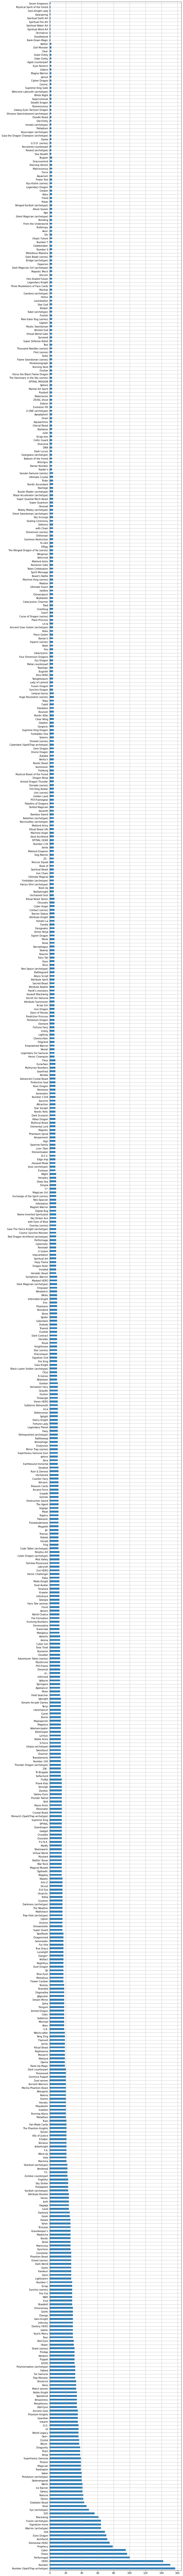

In [147]:
exploded_archseries['Archseries'].value_counts().plot.barh(figsize = (10,200), grid = True)
plt.show()

### By card type

In [88]:
archseries_crosstab = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Card type'], margins = True)
archseries_crosstab

Card type,Monster Card,Spell Card,Trap Card,All
Archseries,,,,
"""C""",8,0,0,8
-Eyes Dragon,71,0,0,71
/Assault Mode,7,0,0,7
@Ignister,18,0,0,18
A-to-Z,16,0,0,16
...,...,...,...,...
sprout,2,0,0,2
tellarknight,17,4,0,21
with Chain,0,0,4,4


### By primary type

In [89]:
archseries_crosstab_b = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Primary type'], margins = True)
archseries_crosstab_b

Primary type,Effect Monster,Fusion Monster,Link Monster,Monster Token,Normal Monster,Ritual Monster,Synchro Monster,Xyz Monster,All
Archseries,,,,,,,,,
"""C""",7,0,0,0,1,0,0,0,8
-Eyes Dragon,31,11,1,0,3,4,5,16,71
/Assault Mode,7,0,0,0,0,0,0,0,7
@Ignister,10,1,4,0,0,1,1,1,18
A-to-Z,6,8,0,0,2,0,0,0,16
...,...,...,...,...,...,...,...,...,...
sphinx,9,0,0,0,0,0,0,0,9
sprout,2,0,0,0,0,0,0,0,2
tellarknight,12,0,0,0,0,0,0,5,17


### By secondary type

In [90]:
archseries_crosstab_c = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Secondary type'], margins = True)
archseries_crosstab_c

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster,All
Archseries,,,,,,,
-Eyes Dragon,0,2,0,2,0,0,4
@Ignister,0,0,0,0,1,0,1
A-to-Z,0,0,0,0,0,6,6
Adamancipator,0,0,0,0,3,0,3
Alien,1,1,0,0,1,0,3
...,...,...,...,...,...,...,...
itsu,0,0,0,0,0,2,2
lswarm,2,0,0,0,0,0,2
roid,0,0,0,0,9,0,9


### By monster type

In [91]:
archseries_crosstab_d = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Monster type'], margins = True)
archseries_crosstab_d

Monster type,Aqua,Beast,Beast-Warrior,Creator God,Cyberse,Dinosaur,Divine-Beast,Dragon,Fairy,Fiend,...,Reptile,Rock,Sea Serpent,Spellcaster,Thunder,Warrior,Winged Beast,Wyrm,Zombie,All
Archseries,,,,,,,,,,,,,,,,,,,,,
"""C""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
-Eyes Dragon,0,0,0,0,0,0,0,66,0,0,...,0,0,0,0,0,0,0,0,3,71
/Assault Mode,0,0,0,0,0,0,0,2,0,0,...,0,0,0,1,0,1,0,0,1,7
@Ignister,0,0,0,0,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
A-to-Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sphinx,0,3,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,9
sprout,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
tellarknight,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,15,0,1,0,17


### By property

In [92]:
archseries_crosstab_e = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Property'], margins = True)
archseries_crosstab_e

Property,Continuous Spell Card,Continuous Trap Card,Counter Trap Card,Equip Spell Card,Field Spell Card,Normal Spell Card,Normal Trap Card,Quick-Play Spell Card,Ritual Spell Card,All
Archseries,,,,,,,,,,
A.I.,1,3,0,0,1,4,1,2,1,13
Abyss Actor,0,0,0,0,0,0,2,0,0,2
Abyss Script,1,0,0,0,0,4,0,1,0,6
Abyss-,0,1,0,3,0,0,3,0,0,7
Adamancipator,0,0,1,0,1,2,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...
sphinx,0,1,0,0,0,0,0,0,0,1
tellarknight,0,0,0,1,1,0,0,2,0,4
with Chain,0,0,0,0,0,0,4,0,0,4


## Artworks

In [142]:
print('Total number of cards with edited or alternate artworks:', formatted_full_df['Artwork'].count())

Total number of cards with edited or alternate artworks: 416


In [97]:
formatted_full_df[['Name','Password','TCG status','OCG status','Artwork']].dropna()

,Name,Password,TCG status,OCG status,Artwork
50,Alluring Mirror Split,92881099,Unlimited,Unlimited,"(Alternate, Edited)"
59,Amazoness Spellcaster,81325903,Unlimited,Unlimited,"(Edited,)"
68,Ancient Gear Castle,92001300,Unlimited,Unlimited,"(Edited,)"
112,Arrivalrivals,29508346,Unlimited,Unlimited,"(Alternate, Edited)"
133,Axe of Despair,40619825,Unlimited,Unlimited,"(Edited,)"
...,...,...,...,...,...
11760,Soitsu,60246171,Unlimited,Unlimited,"(Edited,)"
11811,Stardust Dragon,44508094,Unlimited,Unlimited,"(Alternate,)"
11819,Storming Wynn,29013526,Unlimited,Unlimited,"(Alternate, Edited)"
11846,Thousand Dragon,41462083,Unlimited,Unlimited,"(Alternate,)"


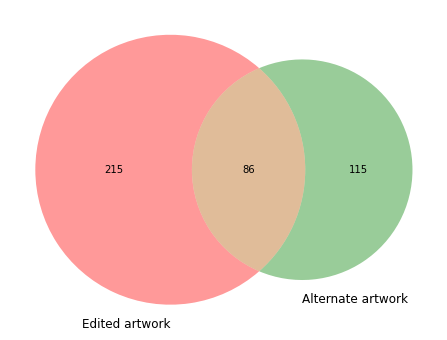

In [150]:
artwork_value_counts = formatted_full_df['Artwork'].value_counts()
plt.figure(figsize=(20,6))
venn2(subsets = (artwork_value_counts[('Edited',)],artwork_value_counts[('Alternate','Edited')],artwork_value_counts[('Alternate',)]), set_labels = ('Edited artwork', 'Alternate artwork'))
plt.show()

## TCG & OCG status

### TGC status

In [151]:
print('Total number of TCG status:', formatted_full_df['TCG status'].nunique())

Total number of TCG status: 7


In [152]:
formatted_full_df.groupby('TCG status', dropna=False).nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,OCG status,Modification date
TCG status,,,,,,,,,,,,,,,,,,,
Forbidden,99,99,3,7,5,2,6,19,12,27,21,2,4,10,46,53,2,4,99
Illegal,38,0,3,3,5,0,6,14,5,11,12,2,2,2,6,7,0,1,38
Legal,20,0,1,0,1,0,5,11,5,6,7,0,0,0,0,13,2,1,20
Limited,81,81,3,7,6,3,6,15,9,20,20,3,2,2,43,40,3,4,81
Not yet released,8,7,1,0,3,0,4,6,8,8,6,0,0,0,6,6,0,1,8
Semi-Limited,9,9,3,4,2,0,3,3,1,3,3,0,0,0,8,8,1,3,9
Unlimited,11165,11162,3,9,7,6,7,24,14,80,75,13,6,59,339,1086,3,4,11038
NaN,518,426,3,9,8,2,7,23,12,53,37,6,5,9,88,117,1,4,512


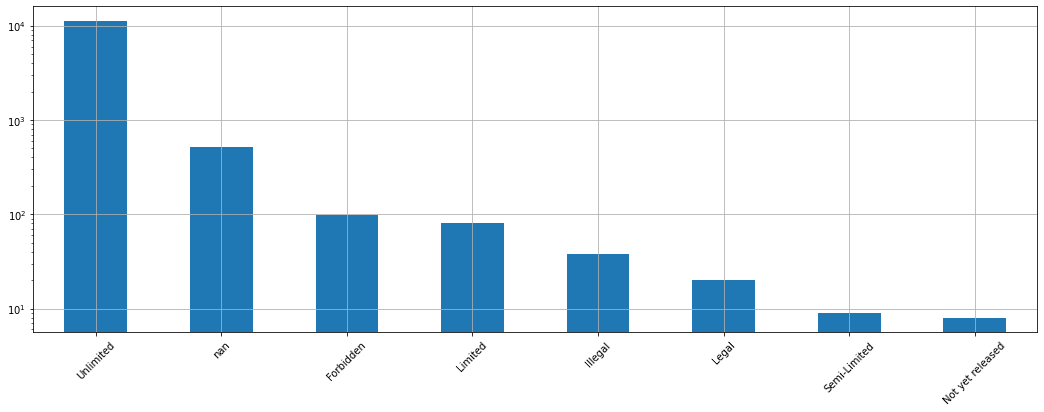

In [154]:
formatted_full_df['TCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)
plt.show()

#### By card type

In [155]:
# Remove unlimited
tcg_crosstab = pd.crosstab(formatted_full_df['Card type'], formatted_full_df['TCG status']).drop(['Unlimited'], axis=1)
tcg_crosstab

TCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Card type,,,,,,
Monster Card,64,35,20,42,8,3
Spell Card,26,2,0,34,0,5
Trap Card,9,1,0,5,0,1


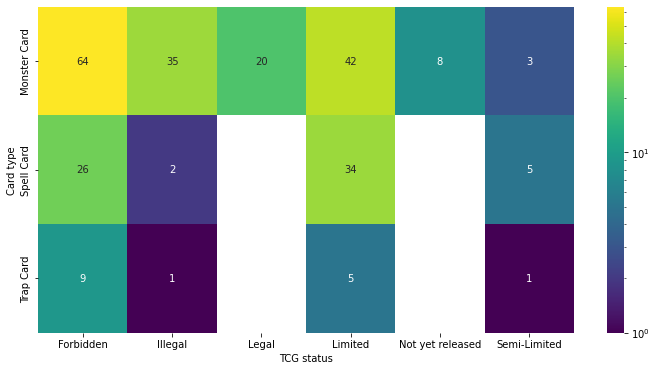

In [157]:
plt.figure(figsize = (12,6))
sns.heatmap(tcg_crosstab, annot=True, fmt="g", cmap='viridis', norm=LogNorm())
plt.show()

#### By monster type

In [158]:
# Remove unlimited
tcg_crosstab_b = pd.crosstab(formatted_full_df['Monster type'], formatted_full_df['TCG status']).drop(['Unlimited'], axis=1)
tcg_crosstab_b

TCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Monster type,,,,,,
Aqua,1,0,2,0,0,0
Beast,0,3,1,2,0,0
Beast-Warrior,2,3,0,2,0,0
Cyberse,2,0,0,1,0,0
Dinosaur,0,0,1,2,0,0
Divine-Beast,0,3,0,0,0,0
Dragon,10,3,1,7,3,0
Fairy,3,4,3,1,1,1
Fiend,5,2,4,3,1,0


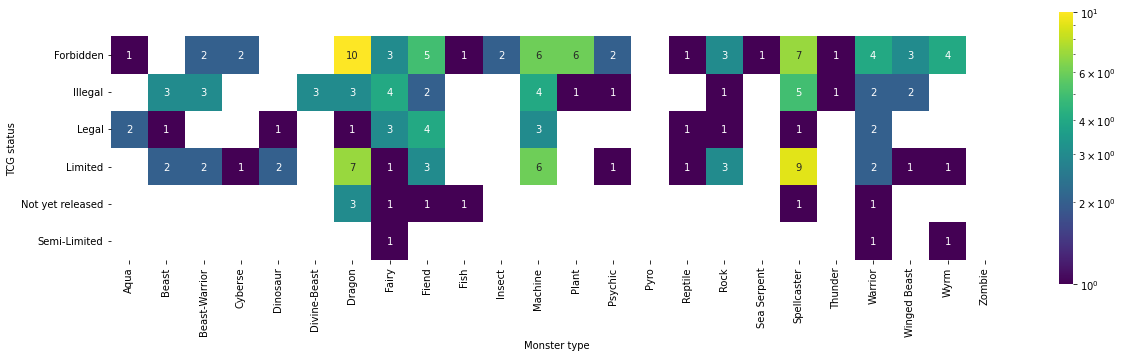

In [160]:
plt.figure(figsize = (20,5))
sns.heatmap(tcg_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square = True, norm=LogNorm())
plt.show()

#### By archseries

In [161]:
# Remove unlimited
tcg_crosstab_c = pd.crosstab(exploded_archseries['Archseries'].where(exploded_archseries['OCG status']!='Unlimited'), exploded_archseries['TCG status'], margins = True)
tcg_crosstab_c

TCG status,Forbidden,Illegal,Legal,Limited,Semi-Limited,Unlimited,All
Archseries,,,,,,,
-Eyes Dragon,1,0,0,0,0,0,1
A-to-Z,0,0,0,0,0,1,1
Adventurer Token (series),0,0,0,0,0,2,2
Amazoness,0,0,0,0,0,1,1
Ancient Gear,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
Zexal,1,0,0,0,0,0,1
Zoodiac,3,0,0,1,0,0,4
roid,0,0,0,1,0,0,1


### OCG status

In [162]:
print('Total number of OCG status:', formatted_full_df['OCG status'].nunique())

Total number of OCG status: 7


In [163]:
formatted_full_df.groupby('OCG status', dropna=False).nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,TCG status,Modification date
OCG status,,,,,,,,,,,,,,,,,,,
Forbidden,87,87,3,7,5,4,6,19,11,28,21,3,4,7,38,43,2,3,87
Illegal,32,1,3,2,6,1,6,12,8,14,15,2,2,2,8,8,0,1,32
Legal,39,0,1,0,2,0,6,17,7,8,8,0,0,0,0,24,2,1,39
Limited,66,66,3,7,6,2,6,13,9,18,17,3,3,5,36,38,2,4,66
Not yet released,42,0,3,7,5,1,6,14,8,18,19,3,1,1,26,13,0,0,42
Semi-Limited,28,28,3,5,3,2,3,9,4,9,7,1,0,0,18,17,0,4,28
Unlimited,11577,11549,3,9,7,6,7,25,14,81,76,13,6,59,347,1114,3,5,11444
NaN,63,50,3,8,6,1,6,17,10,23,22,1,3,4,27,7,0,3,63


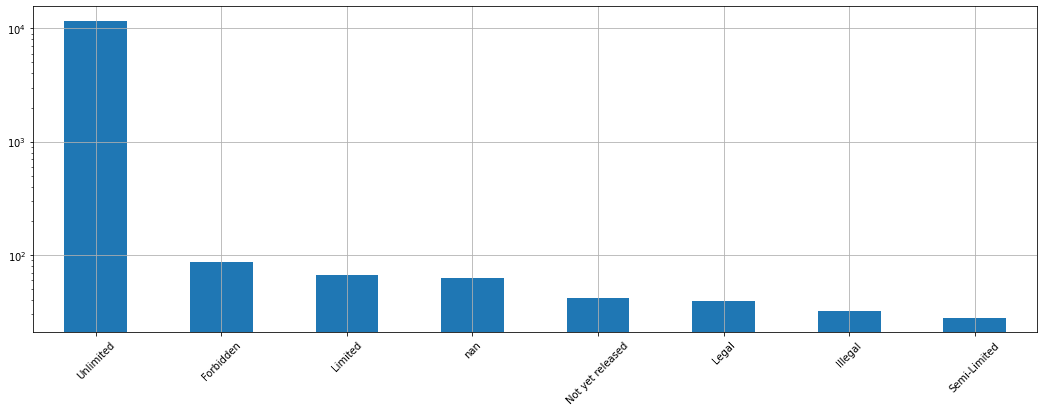

In [165]:
formatted_full_df['OCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)
plt.show()

#### By card type

In [166]:
# Remove unlimited
ocg_crosstab = pd.crosstab(formatted_full_df['Card type'], formatted_full_df['OCG status']).drop(['Unlimited'], axis=1)
ocg_crosstab

OCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Card type,,,,,,
Monster Card,54,30,39,39,27,10
Spell Card,23,1,0,24,11,17
Trap Card,10,1,0,3,4,1


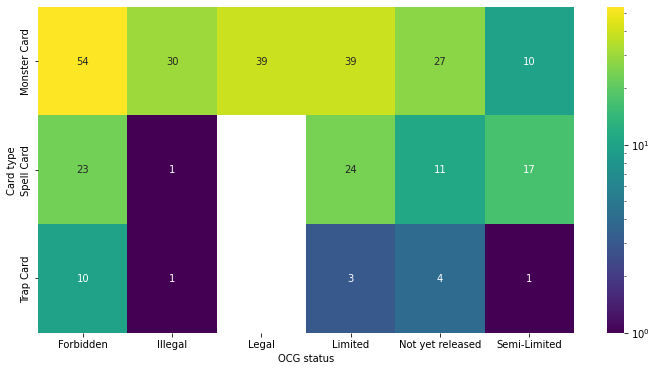

In [168]:
plt.figure(figsize = (12,6))
sns.heatmap(ocg_crosstab, annot=True, fmt="g", cmap='viridis', norm=LogNorm())
plt.show()

#### By monster type

In [169]:
# Remove unlimited
ocg_crosstab_b = pd.crosstab(formatted_full_df['Monster type'], formatted_full_df['OCG status']).drop(['Unlimited'], axis=1)
ocg_crosstab_b

OCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Monster type,,,,,,
Aqua,1,0,2,1,1,0
Beast,1,2,4,0,0,1
Beast-Warrior,3,2,0,1,1,1
Creator God,0,0,0,0,0,0
Cyberse,2,0,2,1,0,0
Dinosaur,0,0,1,1,1,0
Divine-Beast,0,3,0,0,0,0
Dragon,10,3,1,4,2,1
Fairy,2,3,4,0,2,0


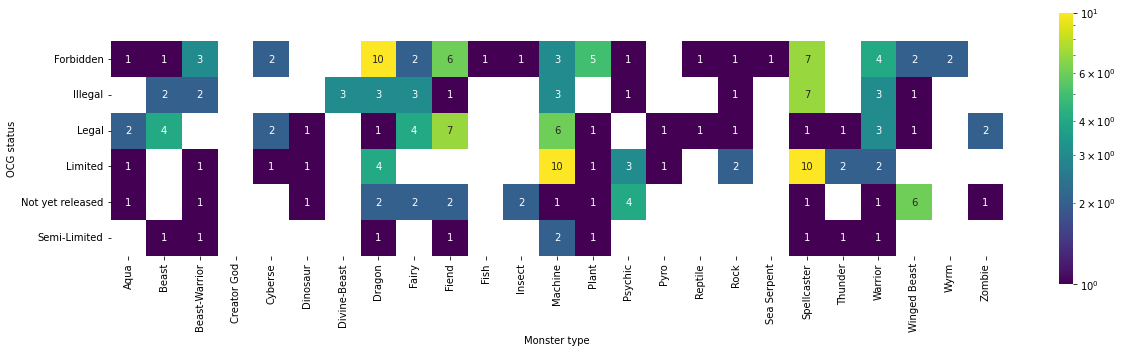

In [171]:
plt.figure(figsize = (20,5))
sns.heatmap(ocg_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square = True, norm=LogNorm())
plt.show()

#### By archseries

In [172]:
# Remove unlimited
ocg_crosstab_c = pd.crosstab(exploded_archseries['Archseries'].where(exploded_archseries['OCG status']!='Unlimited'), exploded_archseries['OCG status'], margins = True)
ocg_crosstab_c

OCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited,All
Archseries,,,,,,,
-Eyes Dragon,1,0,0,0,0,0,1
A-to-Z,0,0,0,1,0,0,1
Adventurer Token (series),0,0,0,2,0,0,2
Amazoness,1,0,0,0,0,0,1
Ancient Gear,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
Zombie counterpart,0,0,1,0,0,0,1
Zoodiac,2,0,0,2,0,0,4
roid,0,0,0,1,0,0,1


### TCG vs. OCG status

In [173]:
cg_crosstab = pd.crosstab(formatted_full_df['OCG status'],formatted_full_df['TCG status'], dropna=False, margins = False)
cg_crosstab

TCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited,Unlimited
OCG status,,,,,,,
Forbidden,72,0,0,5,0,0,10
Illegal,0,26,0,0,0,0,0
Legal,0,0,20,0,0,0,0
Limited,6,0,0,35,0,3,22
Semi-Limited,3,0,0,5,0,3,17
Unlimited,18,0,0,36,7,3,11068


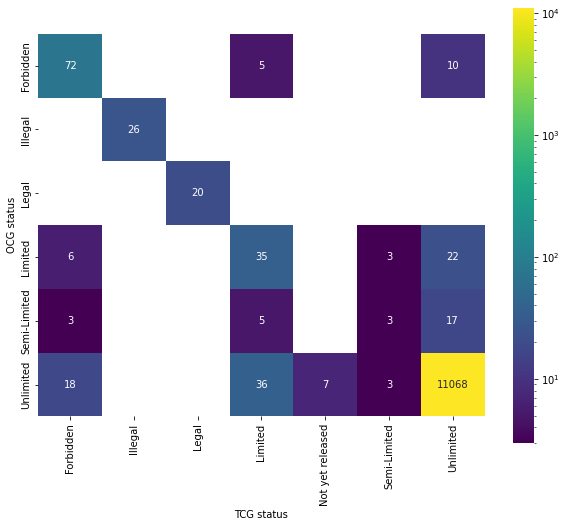

In [175]:
plt.figure(figsize = (10,8))
sns.heatmap(cg_crosstab, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

# HTML export

In [176]:
! jupyter nbconvert Cards.ipynb --to=HTML --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook Cards.ipynb to HTML
[NbConvertApp] Writing 2492206 bytes to Cards.html


# Searches

In [ ]:
formatted_full_df.loc[formatted_full_df['OCG status'] == 'Not yet released'].loc[formatted_full_df['TCG status'] == 'Not yet released']